# Part I: Radiometric Response Function

In [3]:
%matplotlib notebook

import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

7


<IPython.core.display.Javascript object>


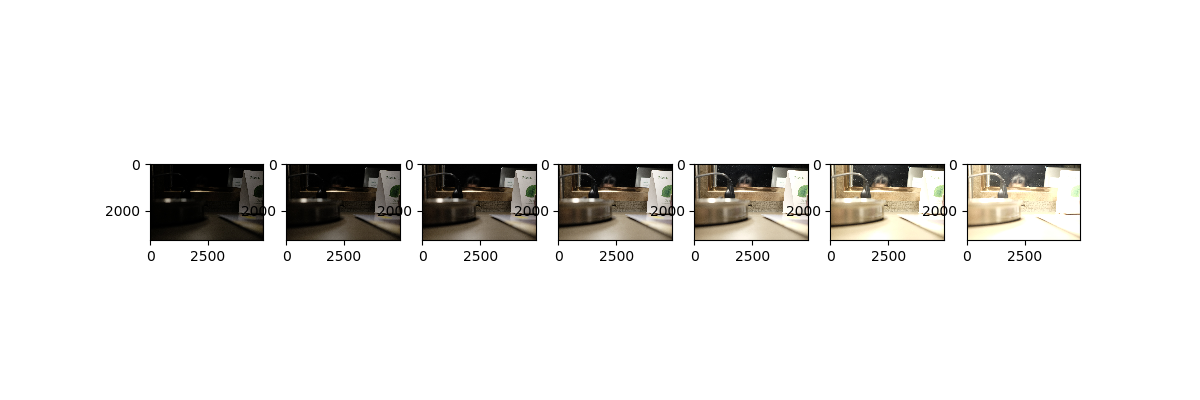

In [4]:
# Init An array of images
scene1 = np.array([ image.imread("images/scene1-"+str(x)+".jpg") for x in range(7)])

# Exposure is -3 -2 -1 0 1 2 3
log_time = np.array([-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0])

#scene1.append(image.imread("images/scene1.jpg"))
print(len(scene1))

# Show The Pics
fig = plt.figure(1,figsize = (12, 4))
plt.subplot(171)
plt.imshow(scene1[0])

plt.subplot(172)
plt.imshow(scene1[1])

plt.subplot(173)
plt.imshow(scene1[2])

plt.subplot(174)
plt.imshow(scene1[3])


plt.subplot(175)
plt.imshow(scene1[4])

plt.subplot(176)
plt.imshow(scene1[5])


plt.subplot(177)
plt.imshow(scene1[6])



In [5]:
# Weight Function
def weight(z):
    return min(z-0.0,255.0-z)

In [6]:
def response_curve_fc(Z, B, l, w): 
    n = 256
    A = np.zeros((Z.shape[0]*Z.shape[1]+n+1, n+Z.shape[0]), dtype=float)
    b = np.zeros((A.shape[0], 1), dtype=float)
    
    k = 0
    for i in range(Z.shape[1]):
        for j in range(Z.shape[0]):
            z = Z[j,i]
            wij = w[z]
            A[k, z] = wij
            A[k, n+i] = -wij
            b[k,0] = wij*B[j]
            k=k+1
    print(k)
    print(n//2)
    A[k,n//2] = 1
    k = k+1
            
    for i in range(1, 255):
        A[k,i-1] = l*w[i]
        A[k,i] = -2*l*w[i]
        A[k,i+1] = l*w[i]
        k=k+1
    
    # Solve the system using SVD
    x = la.lstsq(A, b)[0]
    g = x[:n]
    lE = x[n:]
    
    
    return g, lE

In [58]:
# Small Experimental Code To See if code breaks
# Randomly select 4 locations from 7 pictures
pr = [(46,265),(651,235),(735,1598),(1238,1863)]
print(scene1.shape)
RChan = scene1[:,:,:,0]
GChan = scene1[:,:,:,1]
BChan = scene1[:,:,:,2]
RL = np.array([ RChan[:,x[0],x[1]] for x in pr]).transpose()
GL = np.array([ GChan[:,x[0],x[1]] for x in pr]).transpose()
BL = np.array([ BChan[:,x[0],x[1]] for x in pr]).transpose()

W = np.array([ weight(i) for i in range(257) ])
# Get G function and log(E)
RG,RLE = response_curve_fc(RL,log_time,100,W)
GG,GLE = response_curve_fc(GL,log_time,100,W)
BG,BLE = response_curve_fc(BL,log_time,100,W)
# Need to convert G from (256,1) to (256,)
RG=RG.reshape((256,))
GG=GG.reshape((256,))
BG=BG.reshape((256,))

# need to verify the curve is correct.

(7, 3264, 4896, 3)
28
128


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


28
128
28
128


# Part II: Radiance Map Reconsturction

We used formula 10.10 and 10.11 from Szeliski's book, page 486.

$$
\log E_i = \displaystyle \frac{\sum_jw(z_{ij})[g(z_{ij})-\log t_j]}{\sum_jw(z_{ij})}
$$

Where the weight function is given by 

$$
w(z)=g(z)/g'(z)
$$

In [61]:
def log_E(g,z,logt):
    # Input, g(256,),z(n,w,h),logt(n,)
    # Calculate dG, sum of weight
    dg = np.gradient(g)
    # weight_nwh is the weight matrix same size as z(n,w,h)
    weight_nwh = np.exp(g[z])/dg[z]
    # dim reduce to w by h
    lower = np.sum(weight_nwh,axis=0)
    
    # Calculate w(zij)[g(zij)-log(tj)]
    # Calculate [g(zij)-log(tj)]
    gz = g[z]
    for i in range(logt.shape[0]):
        gz[i] -= logt[i]
    upper = np.sum((weight_nwh * gz),axis=0) # dim reduce to w by h

    logE = upper/lower
    return logE


In [62]:
#print(np.sum(experimentR,axis=0).shape)
#print((experimentR*log_time).shape)
#p1 = experimentR[0]
#print(G[experimentR].shape)
#dG = np.gradient(G)
#print((G[p1]/dG[p1]).shape)
#print(rmap_weight(G,p1).shape)
RlogE = log_E(RG,RChan,log_time)
GlogE = log_E(GG,GChan,log_time)
BlogE = log_E(BG,BChan,log_time)
fig = plt.figure(2,figsize = (12, 4))
# Show R Channel Radiance Map
plt.subplot(131)
plt.imshow(RlogE)

# Show G Channel Radiance Map
plt.subplot(132)
plt.imshow(GlogE)

# Show B Channel Radiance Map
plt.subplot(133)
plt.imshow(BlogE)

<IPython.core.display.Javascript object>

# Part III: Without A Tripod

The idea is to only smaple the matching points to get a response function, when constructing radiance map, we also need to match each point to the correct part in other images. Probably use ransac to do this.